In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dateutil.relativedelta import relativedelta



import numpy as np
import datetime as dtm
import dateutil.parser as dparser
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from mpl_toolkits.basemap import Basemap (rotate, ben's suggestion)



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [2]:

filesdir = "/ocean/gsgarbi/selected_days/"

dirs = os.listdir(filesdir)



Iona = (-123.30898284912109, 49.187351226806641)
S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)
xl=(-126.2,-122.2)
yl=(47.1,51)

In [20]:
def plot(points, title = 'title', picname = "noname", b=0):
    
    
    cmap = plt.get_cmap('nipy_spectral')
    cmap.set_bad('burlywood')


    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)

    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]
    griddata.shape


    griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],
                                                  bins=[100,200],
                                                  range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    

    fig, axs = plt.subplots(1,1,figsize=(4.5,4))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    axs.set_position((0.22,0.1, 0.6,0.6)) #x,y starting positions, wid, hei
    
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    
    axs2.plot(Iona[0], Iona[1], 'ws', ms = 5, markerfacecolor = 'None', 
              markeredgecolor = 'w')

    
#     el = Ellipse((2, -1), 0.5, 0.5)

#     axs2.annotate(
#             "  IONA",
#             xy=(Iona[0], Iona[1]), xytext=(50, 10),
#             textcoords='offset points', ha='left', va='bottom', color = 'black',
#             arrowprops=dict(arrowstyle="wedge,tail_width=1.",
#                                       fc=(1,1,1), ec=(1., .5, .5),
#                                       patchA=None,
#                                       patchB=el,
#                                       relpos=(0.2, 0.8),
#                                       connectionstyle="arc3,rad=-0.1"))

    fb=nc.Dataset('/ocean/gsgarbi/revised_notebooks/ncfiles/bathymetry_201702.nc')

    B = np.copy(fb.variables ['Bathymetry'])
    LON = np.copy(fb.variables ['nav_lon'])
    LAT = np.copy(fb.variables ['nav_lat'])
    fb.close()
   
    axs2.contour(LON,LAT,B,levels=[50,], colors = ['w',], linewidths = [0.8,])
        
    xc = np.mean(points[:,1])
    yc = np.mean(points[:,2])
    xs = np.std(points[:,1])
    ys = np.std(points[:,2])
    
    axs2.plot(xc,yc,"kx", ms = 10)
    
    extra = "Total of trajectories: {} \n".format( 
        int(np.sum(griddata)) ) + "STD: ({}, {})".format(round(xs,2),
                                                        round(ys,2))
    
    axs.set_title( title  + "\n" + 
                 "Centroid: ({}, {})".format (round(xc, 2), round(yc, 2))
                                                        )
    
    #plt.tight_layout()
    
    
    plt.savefig(picname, transparent = True, dpi = 400)
    


In [21]:
end_date = dt.date(2016, 7,1)
nday = 100


def lessthan (filesdir, end_date = dt.date(2016, 7,1), nday = 100, ppd = 72):
    
    
    last_month = end_date.month
    start_date = end_date - relativedelta(days = nday)
    first_month = start_date.month
    
    dirs = os.listdir(filesdir)
    
    #choose and format months
    months = range(first_month, last_month+1)
    fmonths = []
    for m in months:
        
        if len(str(m)) == 1:
            m = "0"+str(m)
            fmonths.append(m)
        else:
            fmonths.append(str(m))
    
    #restricted eligible files in dirs based on nday and enddate so it won't take long
    dirs = sorted ([i for i in dirs if i[4:6] in fmonths])
    
    pts = []
    

    
        
    for day in range (nday):

        loop_date = start_date + dt.timedelta(days = day)

        loop_month = loop_date.month
        
        loop_day = loop_date.day
        days_left = (end_date - loop_date).days


        #format month
        if len (str(loop_month)) == 2:
            fl_m = str(loop_month)
        else:
            fl_m = "0" + str(loop_month)

        print (loop_date, fl_m, days_left)
        

        #select the file we want
        for file in dirs:
            
            
            if "{}d.npy".format(days_left) == file[18:] and fl_m == file[4:6]:

                
                array = np.load(open(filesdir + file, 'rb'))
                
                print (array)
                
                
                #select the 72 trajectories from the day in the current month that we need
                array = array [ppd*(loop_day-1):ppd*(loop_day)]

                pts.append(array)
                
                print (len (np.array([i for sublist in pts for i in sublist])))
                
                
    #flatten the list
    pts = np.array([i for sublist in pts for i in sublist])

    
    return pts

2016-08-23 08 100
[[  1.00000000e+00  -1.24856530e+02   4.85903800e+01  -4.81695900e+01
    4.04860000e-01]
 [  2.00000000e+00  -1.23824940e+02   4.93127500e+01  -2.85175400e+02
    4.04860000e-01]
 [  3.00000000e+00  -1.22770380e+02   4.83251000e+01  -6.55905800e+01
    4.04860000e-01]
 ..., 
 [  2.15800000e+03  -1.22882650e+02   4.87780800e+01  -3.97873000e+01
    4.04860000e-01]
 [  2.15900000e+03  -1.23349170e+02   4.89251300e+01  -6.22615400e+01
    4.04860000e-01]
 [  2.16000000e+03  -1.25092290e+02   5.00471900e+01  -1.29072330e+02
    4.04860000e-01]]
72
2016-08-24 08 99
[[  1.00000000e+00  -1.24874550e+02   4.86118100e+01  -4.81695900e+01
    4.00810000e-01]
 [  2.00000000e+00  -1.23846390e+02   4.92963000e+01  -2.76842410e+02
    4.00810000e-01]
 [  3.00000000e+00  -1.22788380e+02   4.83392600e+01  -8.22142700e+01
    4.00810000e-01]
 ..., 
 [  2.15800000e+03  -1.22913090e+02   4.88055400e+01  -7.51939900e+01
    4.00810000e-01]
 [  2.15900000e+03  -1.23298580e+02   4.8887930

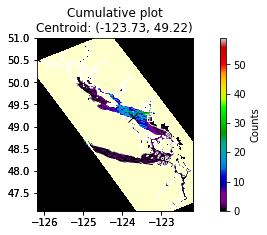

In [22]:
end_date = dt.date(2016, 12,1)
nday = 100

points = lessthan(filesdir, nday = nday, end_date = end_date)


title = (
    "Density plot for final positions for trajectory lengths /n less than {} days before {}".format(nday, end_date)
)

title = ("Cumulative plot"
    
)

picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(end_date, nday)

plot (points, title, picname)


plt.show()

2016-05-24 05 100
[[  1.00000000e+00  -1.23301220e+02   4.93947900e+01  -1.19740570e+02
    3.08640000e-01]
 [  2.00000000e+00  -1.23460270e+02   4.89607100e+01  -4.72675800e+01
    3.08640000e-01]
 [  3.00000000e+00  -1.23228980e+02   4.88777800e+01  -1.09623400e+02
    3.08640000e-01]
 ..., 
 [  2.15800000e+03  -1.24258260e+02   4.94132700e+01  -2.69205380e+02
    3.08640000e-01]
 [  2.15900000e+03  -1.24426110e+02   4.95813900e+01  -7.87698400e+01
    3.08640000e-01]
 [  2.16000000e+03  -1.23350680e+02   4.95448000e+01  -3.11131000e+00
    3.08640000e-01]]
72
2016-05-25 05 99
[[  1.00000000e+00  -1.23299490e+02   4.94238900e+01  -1.13517280e+02
    3.05560000e-01]
 [  2.00000000e+00  -1.23533510e+02   4.89928100e+01  -6.63704500e+01
    3.05560000e-01]
 [  3.00000000e+00  -1.23266040e+02   4.89016700e+01  -9.79310900e+01
    3.05560000e-01]
 ..., 
 [  2.15800000e+03  -1.24248080e+02   4.94156100e+01  -2.72766210e+02
    3.05560000e-01]
 [  2.15900000e+03  -1.24415470e+02   4.9535810

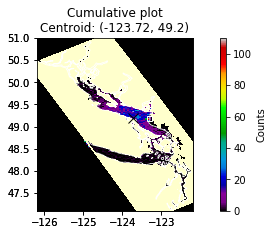

In [23]:
end_date = dt.date(2016, 9,1)
nday = 100

points = lessthan(filesdir, nday = nday, end_date = end_date)


title = (
    "Density plot for final positions for trajectory lengths less than {} days before {}".format(nday, end_date)
)

title = "Cumulative plot"


picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(end_date, nday)

plot (points, title, picname)


plt.show()

In [ ]:
+